In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import ROOT
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import root_pandas as rp
from root_pandas import read_root
import pandas as pd
            
sys.path.append('/home/vmueller/repos/')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls, build_tchain_from_files
from dopy.doplot.plotting import Plotter, Plot
import dopy.doroot.rootnotes 
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe

In [2]:
triggerlines = '&(Hlt1DiMuonHighMassDecision==1|Hlt1TrackMuonDecision==1)&Hlt2DiMuonDetachedJPsiDecision==1'

### Sanity cuts:  



In [41]:
sanity_cuts = [ 'B0_FitPVConst_MERR_flat<30',
        'B0_FitPVConst_tauErr_flat<0.0002',
        'PVZ<250',
        '(B0_OWNPV_CHI2/B0_OWNPV_NDOF)<10',
        '(J_psi_1S_OWNPV_CHI2/J_psi_1S_OWNPV_NDOF)<16',
        '(KS0_OWNPV_CHI2/KS0_OWNPV_NDOF)<20',
        'B0_FitPVConst_J_psi_1S_P1_PT>500',
        'muminus_TRACK_CHI2NDOF<3',
        'muminus_PIDmu>0',
        'B0_FitPVConst_KS0_P0_P_flat>2000',
        '(piminus_MINIPCHI2/piminus_OWNPV_NDOF)>4',
        'B0_FitDaughtersPVConst_status==0',
        'B0_FitPVConst_status==0',
        'muplus_TRACK_GhostProb<0.2',
        'muminus_TRACK_GhostProb<0.2',
        'piplus_TRACK_GhostProb<0.3',
        'piminus_TRACK_GhostProb<0.3',]
s = '&'
sanity_cuts = s.join(sanity_cuts)

In [42]:
sanity_cuts = sanity_cuts  + triggerlines

## Daughter cuts 

In [43]:
daughter_cuts = [
                '(abs(B0_FitDaughtersConst_J_psi_1S_M_flat-3096.916)<60)',
                '(((abs(B0_FitDaughtersConst_KS0_M_flat-497.614)<55)&(muminus_TRACK_Type==5))|((abs(B0_FitDaughtersConst_KS0_M_flat-497.614)<15)&muminus_TRACK_Type==3))'
                ]

In [44]:
s = '&'
daughter_cuts = s.join(daughter_cuts)

In [45]:
cuts_complete = sanity_cuts + '&' + daughter_cuts

In [46]:
cuts_complete

'B0_FitPVConst_MERR_flat<30&B0_FitPVConst_tauErr_flat<0.0002&PVZ<250&(B0_OWNPV_CHI2/B0_OWNPV_NDOF)<10&(J_psi_1S_OWNPV_CHI2/J_psi_1S_OWNPV_NDOF)<16&(KS0_OWNPV_CHI2/KS0_OWNPV_NDOF)<20&B0_FitPVConst_J_psi_1S_P1_PT>500&muminus_TRACK_CHI2NDOF<3&muminus_PIDmu>0&B0_FitPVConst_KS0_P0_P_flat>2000&(piminus_MINIPCHI2/piminus_OWNPV_NDOF)>4&B0_FitDaughtersPVConst_status==0&B0_FitPVConst_status==0&muplus_TRACK_GhostProb<0.2&muminus_TRACK_GhostProb<0.2&piplus_TRACK_GhostProb<0.3&piminus_TRACK_GhostProb<0.3&(Hlt1DiMuonHighMassDecision==1|Hlt1TrackMuonDecision==1)&Hlt2DiMuonDetachedJPsiDecision==1&(abs(B0_FitDaughtersConst_J_psi_1S_M_flat-3096.916)<60)&(((abs(B0_FitDaughtersConst_KS0_M_flat-497.614)<55)&(muminus_TRACK_Type==5))|((abs(B0_FitDaughtersConst_KS0_M_flat-497.614)<15)&muminus_TRACK_Type==3))'

## Create tuple with the RUN1 cuts

In [47]:
create_sanity_tuple = True

In [48]:
variables = ['B0_FitDaughtersConst_M_flat',
            'idxPV',
            'piminus_TRACK_CHI2NDOF',
            #'piminus_IPCHI2',
            'piplus_TRACK_CHI2NDOF',
            #'piplus_IPCHI2',
            #'piminus_OWNPV_NDOF',
            #'piminus_OWNPV_NDOF',
            ]

tree_data = 'Bd2JpsiKs'
if create_sanity_tuple==True:
    #directories and files for 2015
    data_file_2015 = 'Bd2JpsimumuKS_data_2015_flat.root'
    data_dir_2015 = '/fhgfs/users/chasenberg/data/2015/jpsimumuks/'
    data_2015 = data_dir_2015 + data_file_2015
    #read from ROOT-fil
    print("Reading 2015 data.")
    df_2015 = rp.read_root(data_2015,key=tree_data, columns=variables,where=cuts_complete, flatten=False)
    df_2015 = df_2015.replace([np.inf, -np.inf], np.nan)
    df_2015 = df_2015.dropna()
    #directories and files for 2015
    data_file_2016 = 'Bd2JpsimumuKS_data_2016_flat.root'
    data_dir_2016 = '/fhgfs/users/chasenberg/data/2016/jpsimumuks/'
    data_2016 = data_dir_2016 + data_file_2016
    #read from ROOT-file
    print("Reading 2016 data.")
    df_2016 = rp.read_root(data_2016,key=tree_data, columns=variables,where=cuts_complete, flatten=False)
    df_2016 = df_2016.replace([np.inf, -np.inf], np.nan)
    df_2016 = df_2016.dropna()
    print("Merging 2015+2016 data and write to ROOT file.")
    df_merged = pd.concat([df_2015,df_2016])
    #add symmetric variables
    from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe
    add_max_to_dataframe(df_merged, 'pi_TRACK_CHI2NDOF_max', ['piminus_TRACK_CHI2NDOF', 'piplus_TRACK_CHI2NDOF'])
    data_dir_2015_2016 = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/'
    

Reading 2015 data.
Reading 2016 data.
Merging 2015+2016 data and write to ROOT file.


In [49]:
df_merged.query('pi_TRACK_CHI2NDOF_max<3').to_root(data_dir_2015_2016+'Bd2JpsiKS_run1.root',key='Bd2JpsiKS')

## Massift

In [50]:
sys.path.append('/home/chasenberg/repos/root_utils/')
from ROOT import TColor
import rootnotes  # For displaying TCanvas in notebooks
from lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   
from root_utils import plot_pulls

from ROOT import RooRealVar, RooExponential,kBlue, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian, kDotted, RooFormulaVar, kRed
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

In [51]:
# Read data and fit it
dataset_file_path = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/'

file_name = 'Bd2JpsiKS_run1.root'

data = ROOT.TFile(dataset_file_path + file_name)
tree_data = data.Get('Bd2JpsiKS') 

In [52]:
#Mass variable
mass         = RooRealVar("B0_FitDaughtersConst_M_flat", "m_{J/psi K_{S}^{0}}", 5280,5220, 5450, "MeV")
idxPV        = RooRealVar("idxPV", "idxPV", 0,0,0)
ntupleVarSet =  RooArgSet(mass,idxPV)
dataset      = RooDataSet('data','data',tree_data,ntupleVarSet)

In [53]:
postfix = ''

par_ipatia_zeta  = RooRealVar('par_ipatia_zeta'  + postfix,  'par_ipatia_zeta'  + postfix, 3.25588)#, 0.3, 5.3)
par_ipatia_fb    = RooRealVar('par_ipatia_fb'    + postfix,    'par_ipatia_fb'  + postfix, 0.)#, 0., 10.)
par_ipatia_l     = RooRealVar('par_ipatia_l'     + postfix,     'par_ipatia_l'  + postfix, -3.17)#1., 1., 1.)
par_ipatia_m     = RooRealVar('par_ipatia_m'     + postfix,     'par_ipatia_m'  + postfix, 5279, 5200., 5400.,)
par_ipatia_sigma = RooRealVar('par_ipatia_sigma' + postfix, 'par_ipatia_sigma'  + postfix, 7.94441, 2., 100.)
par_ipatia_a1    = RooRealVar('par_ipatia_a1'    + postfix,     'par_ipatia_a1' + postfix, 1.76044)#, 0.01, 4)
par_ipatia_a2    = RooRealVar('par_ipatia_a2'    + postfix,     'par_ipatia_a2' + postfix, 1.88748)#, 0.01, 4)
par_ipatia_n1    = RooRealVar('par_ipatia_n1'    + postfix,     'par_ipatia_n1' + postfix, 4.76854)#, 0.00001, 150.)
par_ipatia_n2    = RooRealVar('par_ipatia_n2'    + postfix,     'par_ipatia_n2' + postfix, 6.76837)#, 0.00001, 150.)'''

par_ipatia_zeta  = RooRealVar('par_ipatia_zeta'  + postfix,  'par_ipatia_zeta'  + postfix, 0.,0.,0.)#, 1., 5.3)
par_ipatia_fb    = RooRealVar('par_ipatia_fb'    + postfix,    'par_ipatia_fb'  + postfix, 0.,0.,0.)
par_ipatia_l     = RooRealVar('par_ipatia_l'     + postfix,     'par_ipatia_l'  + postfix, -2.718,-2.718,-2.718)
par_ipatia_m     = RooRealVar('par_ipatia_m'     + postfix,     'par_ipatia_m'  + postfix, 5280.5, 5220., 5400.,)
par_ipatia_sigma = RooRealVar('par_ipatia_sigma' + postfix, 'par_ipatia_sigma'  + postfix, 8.71582, 2., 12.)
par_ipatia_a1    = RooRealVar('par_ipatia_a1'    + postfix,     'par_ipatia_a1' + postfix,  2.32234,2.32234,2.32234)#3.,3.,3.)
par_ipatia_a2    = RooRealVar('par_ipatia_a2'    + postfix,     'par_ipatia_a2' + postfix,  3.414,3.414,3.414)#2.91222, 2.91222, 2.91222)
par_ipatia_n1    = RooRealVar('par_ipatia_n1'    + postfix,     'par_ipatia_n1' + postfix, 3.,3.,3.)
par_ipatia_n2    = RooRealVar('par_ipatia_n2'    + postfix,     'par_ipatia_n2' + postfix, 3.,3.,3.)

pdf_mass_ipatia  = ROOT.RooIpatia2('pdf_mass_ipatia', 'pdf_mass_ipatia', mass, par_ipatia_l, par_ipatia_zeta, par_ipatia_fb,
                               par_ipatia_sigma, par_ipatia_m, par_ipatia_a1, par_ipatia_n1,
                               par_ipatia_a2, par_ipatia_n2)
    
ROOT.SetOwnership( pdf_mass_ipatia, False )
ROOT.SetOwnership( par_ipatia_zeta, False )
ROOT.SetOwnership( par_ipatia_fb, False )
ROOT.SetOwnership( par_ipatia_l, False )
ROOT.SetOwnership( par_ipatia_m, False )
ROOT.SetOwnership( par_ipatia_sigma, False )
ROOT.SetOwnership( par_ipatia_a1, False )
ROOT.SetOwnership( par_ipatia_n1, False )
ROOT.SetOwnership( par_ipatia_a2, False )
ROOT.SetOwnership( par_ipatia_n2, False )

sig_yield = RooRealVar('sig_yield' + postfix, 'sig_yield' + postfix, 160000, 0, 250000)
ROOT.SetOwnership( sig_yield, False )

sig_pdf_ext = RooExtendPdf('sig_pdf_ext' + postfix, 'sig_pdf_ext' + postfix, pdf_mass_ipatia, sig_yield)
ROOT.SetOwnership( sig_pdf_ext, False )
 
exp_a = RooRealVar('exp_a' + postfix, 'exp_a' + postfix, -0.001, -0.01, -0.00001)
exp   = RooExponential('exp' + postfix, 'exp' + postfix, mass, exp_a)
bkg_pdf = exp
bkg_yield = RooRealVar('bkg_yield' + postfix, 'bkg_yield' + postfix, 1849830, 0, 2000000)
ROOT.SetOwnership( exp_a, False )
ROOT.SetOwnership( bkg_pdf, False )
ROOT.SetOwnership( bkg_yield, False)

bkg_pdf_ext = RooExtendPdf('bkg_pdf_ext' + postfix, 'bkg_pdf_ext' + postfix, bkg_pdf, bkg_yield)
ROOT.SetOwnership( bkg_pdf_ext, False)

par_ipatia_m_bs_shift = RooRealVar("par_ipatia_m_bs_shift" + postfix, "par_ipatia_m_bs_shift" + postfix, 87.0, 50.0, 100.0)
par_ipatia_m_bs = RooFormulaVar("par_ipatia_m_bs" + postfix, "par_ipatia_m_bs" + postfix, "@0+@1", RooArgList(par_ipatia_m, par_ipatia_m_bs_shift))
#par_ipatia_m_bs = RooRealVar("par_ipatia_m_bs"    + postfix,    "par_ipatia_m_bs" + postfix,    5366, 5300., 5400.,)
                    
pdf_mass_ipatia_bs  = ROOT.RooIpatia2('pdf_mass_ipatia_bs', 'pdf_mass_ipatia_bs', mass, par_ipatia_l, par_ipatia_zeta, par_ipatia_fb,
                                   par_ipatia_sigma, par_ipatia_m_bs, par_ipatia_a1, par_ipatia_n1, par_ipatia_a2, par_ipatia_n2)
    
bs_yield = RooRealVar('bs_yield' + postfix, 'bs_yield' + postfix, 4794, 0, 40000)
ROOT.SetOwnership( par_ipatia_m_bs_shift, False )
ROOT.SetOwnership( par_ipatia_m_bs, False)
ROOT.SetOwnership( bs_yield, False)
ROOT.SetOwnership( pdf_mass_ipatia_bs, False)

bs_pdf_ext = RooExtendPdf('bs_pdf_ext' + postfix, 'bs_pdf_ext' + postfix, pdf_mass_ipatia_bs, bs_yield)
ROOT.SetOwnership( bs_pdf_ext, False)

data_model = RooAddPdf('model' + postfix, 'model' + postfix, RooArgList(sig_pdf_ext, bkg_pdf_ext, bs_pdf_ext))
ROOT.SetOwnership( data_model, False )

In [54]:
#Fit model to dataset
data_model.fitTo(dataset, RooFit.NumCPU(6),
                                      RooFit.Minimizer('Minuit','minimize'),
                                      RooFit.Hesse(True),
                                      RooFit.Optimize(0),
                                      RooFit.PrintEvalErrors(0),
                                      RooFit.Save(True),
                                      RooFit.Extended(),
                                      RooFit.Verbose(True)) 

<ROOT.RooFitResult object ("fitresult_model_data") at 0x1cb5c7e0>

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can


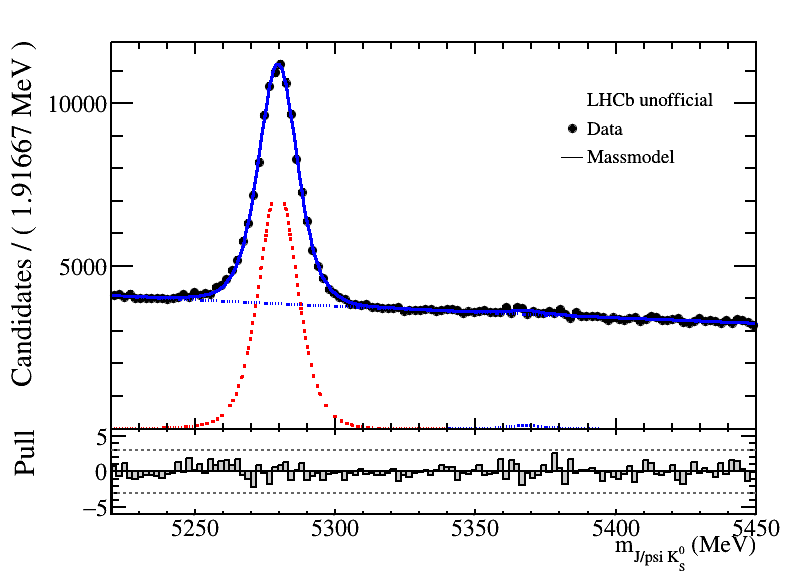

In [55]:
# Prepare frame
%matplotlib inline  
import ROOT




frame = mass.frame(ROOT.RooFit.Bins(120))

dataset.plotOn(frame, ROOT.RooFit.Name("data1"))

data_model.plotOn( frame , ROOT.RooFit.Components("sig_pdf_ext"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kRed))
data_model.plotOn( frame , ROOT.RooFit.Components("bkg_pdf_ext"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kBlue))
data_model.plotOn( frame , ROOT.RooFit.Components("bs_pdf_ext"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kBlue))
data_model.plotOn(frame, ROOT.RooFit.Name("fit"))
### Add additional informations to the plot
text_size = 0.035
# Create TLegend
#legend = ROOT.TLegend(0.7, 0.75, 0.9, 0.9, '')
legend = ROOT.TLegend(0.7, 0.7,0.85,0.85)
legend.AddEntry(0,"LHCb unofficial", "")
legend.AddEntry(frame.findObject('data1'), "Data", "p");
legend.AddEntry(frame.findObject('sig_pdf_ext'), 'Massmodel', 'kBluw')

#legend.AddEntry(frame.findObject('bs_pdf_ext'), 'bs_pdf_ext', 'l')
#legend.AddEntry(frame.findObject('bkg_pdf_ext'), 'bkg_pdf_ext', 'l')
legend.SetTextSize(text_size)
frame.GetYaxis().SetTitle(frame.GetYaxis().GetTitle().replace("Events", "Candidates"))
# Plot pulls
can, _ = plot_pulls('Hallo', frame, legend=legend, logy=False)#, latex=latex)
can.SaveAs("/home/chasenberg/plots/massfit/B0_Mass_run1_selection.pdf")
can  # To display plot in notebooks

In [56]:
par_ipatia_sigma.getVal(),par_ipatia_sigma.getError()

(8.957185306960339, 0.06788325854692001)

In [57]:
par_ipatia_m.getVal(),par_ipatia_m.getError()

(5279.445807506264, 0.04874812107118487)

In [58]:
sig_yield.getVal(),sig_yield.getError()

(72049.79537297187, 480.4408847438899)

In [59]:
bkg_yield.getVal(),bkg_yield.getError()

(438492.71253699396, 841.3187761782028)